# Аналитика в Яндекс.Афише

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Шаг 1. Загрузим данные и подготовим их к анализу
<a id="preprocessing"></a>

In [ ]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [ ]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [ ]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [ ]:
visits.columns

Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')

Изменим названия столбцов в таблице visits

In [ ]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [ ]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [ ]:
visits.duplicated().sum()

0

In [ ]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [ ]:
orders.columns

Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')

In [ ]:
orders.columns = ['buy_ts', 'revenue', 'uid']

In [ ]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [ ]:
orders.duplicated().sum()

0

In [ ]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [ ]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [ ]:
costs.columns

Index(['source_id', 'dt', 'costs'], dtype='object')

In [ ]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [ ]:
costs.duplicated().sum()

0

### Вывод:
Изучили информацию о данных в таблицах. Где необходимо заменили тип данных на дату и время, заменили названия столбцов для удобного обращения к ним. И проверили наличие дубликатов. 

## Шаг 2. Построим отчёты и посчитаем метрики
<a id="step2"></a>

#### Продукт
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

##### Сколько людей пользуются в день, неделю, месяц?
<a id="product1"></a>

В таблице visits добавим столбцы с датой, неделей, месяцем и годом посещения сайта и рассчитаем метрики dau, wau и mau.

In [ ]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [ ]:
visits['date'] = visits['start_ts'].dt.date
visits['week'] = visits['start_ts'].dt.week
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year

In [ ]:
dau = visits.groupby('date').agg({'uid': 'nunique'}).reset_index() # количество посещений в день
dau.head()

,date,uid
0,2017-06-01,605
1,2017-06-02,608
2,2017-06-03,445
3,2017-06-04,476
4,2017-06-05,820


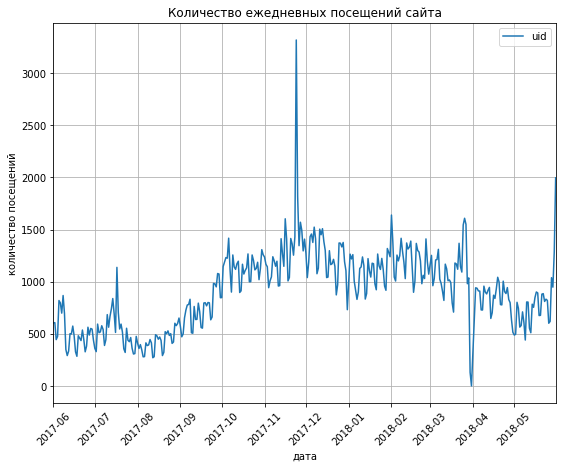

In [ ]:
dau.plot(x='date', y='uid', figsize=(9,7), grid=True)
plt.xticks(rotation = 45)
plt.title('Количество ежедневных посещений сайта')
plt.xlabel('дата')
plt.ylabel('количество посещений')
plt.show()

In [ ]:
dau['uid'].describe()

count     364.000000
mean      907.991758
std       370.513838
min         1.000000
25%       594.000000
50%       921.000000
75%      1173.000000
max      3319.000000
Name: uid, dtype: float64

In [ ]:
dau.loc[dau['uid'] == 3319]

,date,uid
176,2017-11-24,3319


In [ ]:
dau.loc[dau['uid'] == 1]

,date,uid
303,2018-03-31,1


In [ ]:
dau['uid'].mean()

907.9917582417582

In [ ]:
wau = visits.groupby(['year', 'week']).agg({'uid': 'nunique'}) # количество посещений в неделю
wau.head()

uid
year week      
2017 22    2021
     23    4129
     24    2812
     25    2878
     26    3064

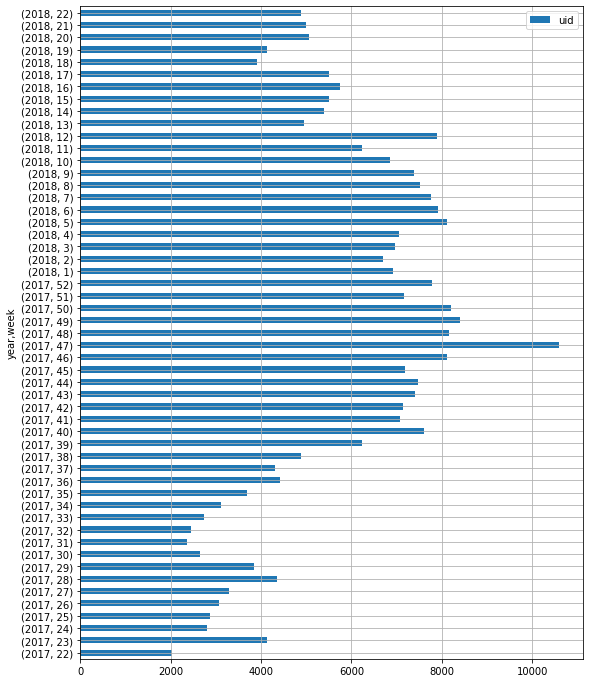

In [ ]:
wau.plot(kind='barh', figsize=(9,12), grid=True)

In [ ]:
wau['uid'].mean()

5716.245283018868

In [ ]:
mau = visits.groupby(['year', 'month']).agg({'uid': 'nunique'}) # количество посещений в месяц
mau.head()

uid
year month       
2017 6      13259
     7      14183
     8      11631
     9      18975
     10     29692

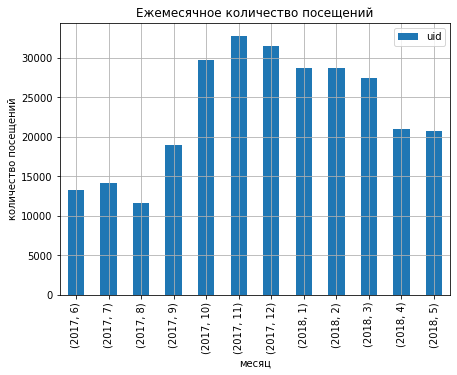

In [ ]:
mau.plot(grid=True, figsize=(7,5), kind='bar')
plt.title('Ежемесячное количество посещений')
plt.xlabel('месяц')
plt.ylabel('количество посещений')
plt.show()

In [ ]:
mau['uid'].mean()

23228.416666666668

In [ ]:
visits.groupby('device')['uid'].agg('count').reset_index()

,device,uid
0,desktop,262567
1,touch,96833


Вывод:

В среднем сайт ежедневно посещают 907 человек. Замечаем большой выброс в количетсве просмотров. Смотрим дату, 24 ноября 2017 года было 3319 просмотров сайта. Наиболее логичное объяснение такого большго спроса, является то, что на эту дату приходилась "черная пятница", день масштабных распродаж и скидок. Самое низкое количество посещений приходится на 31 марта 2018 года. В этот день сайт посетил всего один человек. Скорее всего, можем предположить, что в этот день на сайте производились технические работы и пользователи не могли зайти. В распределение количества посещений по неделям и месяцем наблюдается та же закономерность, что и по дням. Максимум приходится на ноябрь и декабрь.

##### Сколько сессий в день?
<a id="product2"></a>

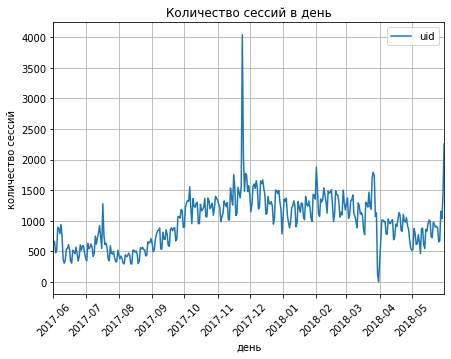

In [ ]:
session_count = visits.groupby('date').agg({'uid': 'count'})
session_count.plot(figsize=(7,5), grid=True)
plt.xticks(rotation = 45)
plt.title('Количество сессий в день')
plt.xlabel('день')
plt.ylabel('количество сессий')
plt.show()

In [ ]:
session_count['uid'].describe()

count     364.000000
mean      987.362637
std       418.994796
min         1.000000
25%       635.500000
50%      1003.000000
75%      1280.000000
max      4042.000000
Name: uid, dtype: float64

В среднем в день сайт посещают 987 раз. Можем сказать, что в целом количество уникальных пользователей почти одинаково с количеством ежедневных сессий, что говорит о том, что пользователи не заходят больше одного раза в день на сайт.

##### Сколько длится одна сессия?
<a id="product3"></a>

In [ ]:
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds() / 60

In [ ]:
visits['session_duration'].describe()

count    359400.000000
mean         10.717095
std          16.618796
min         -46.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_duration, dtype: float64

Видим, что есть отрицательные значения длины сессии. Сделаем срез, исключив все отрицательные значения

In [ ]:
visits = visits.query('session_duration >= 0')

In [ ]:
visits['session_duration'].describe()

count    359398.000000
mean         10.717371
std          16.618420
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_duration, dtype: float64

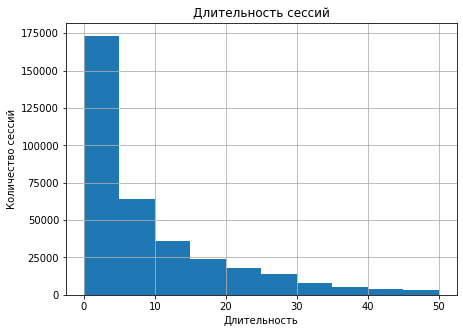

In [ ]:
visits['session_duration'].hist(range=(0,50), figsize=(7,5))
plt.title('Длительность сессий')
plt.xlabel('Длительность')
plt.ylabel('Количество сессий')
plt.show()

In [ ]:
visits.groupby('month')['session_duration'].agg('mean')

month
1     10.883334
2     10.752453
3     10.944491
4     10.012449
5     10.263770
6     10.000402
7     10.077271
8      9.818232
9      9.953174
10    10.241435
11    11.890127
12    11.577994
Name: session_duration, dtype: float64

В среднем пользователи проводят на сайте 10 минут. И от дня недели или месяца это особо не зависит.

##### Как часто люди возвращаются?
<a id="product4"></a>

Сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды покажет Retention Rate. По таблице visits найдем месяц первого посещения сайта для каждого плользователя. И добавим данные в таблицу с посещениями.

In [ ]:
first_visit = visits.groupby('uid')['start_ts'].min().reset_index()
first_visit.columns = ['uid', 'first_visit']
visits = visits.merge(first_visit, on='uid')

Добавим столбцы с месяцем посещения и первым месяцем посещения в формате первого дня месяца.

In [ ]:
visits['activity_month'] = pd.to_datetime(visits['start_ts'], unit='d') - pd.to_timedelta(visits['start_ts'].dt.month, unit='d')
visits['first_activity_month'] = pd.to_datetime(visits['first_visit'], unit='d') - pd.to_timedelta(visits['first_visit'].dt.month, unit='d')

In [ ]:
visits['activity_month'] = visits['activity_month'].astype('datetime64[M]')
visits['first_activity_month'] = visits['first_activity_month'].astype('datetime64[M]')

In [ ]:
visits.head()

,device,end_ts,source_id,start_ts,uid,date,week,month,year,session_duration,first_visit,activity_month,first_activity_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,18.0,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,28.0,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0.0,2017-07-01 01:54:00,2017-06-01,2017-06-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,24.0,2018-03-09 20:05:00,2018-05-01,2018-03-01
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,10,3,2018,28.0,2018-03-09 20:05:00,2018-03-01,2018-03-01


Объединим данные в когорты

In [ ]:
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int') 

In [ ]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 

Получили таблицу с когортами, где first_activity_month обозначает номер когорты, cohort_lifetime - порядновый номер месяц с начала первого посещения когорты сайта и uid - количество активных пользователей в этом месяце

In [ ]:
cohorts.head()

,first_activity_month,cohort_lifetime,uid
0,2017-05-01,0,3468
1,2017-05-01,1,485
2,2017-05-01,2,269
3,2017-05-01,3,268
4,2017-05-01,4,325


In [ ]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]

In [ ]:
initial_users_count # количество пользователей в каждой когорте

,first_activity_month,uid
0,2017-05-01,3468
13,2017-06-01,12562
25,2017-07-01,12531
36,2017-08-01,12406
46,2017-09-01,21073
55,2017-10-01,25923
63,2017-11-01,28698
70,2017-12-01,15853
76,2018-01-01,23914
81,2018-02-01,22279


In [ ]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

In [ ]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_month') 
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

Нашли retention разделив количество активных пользователей за месяц на общее количество пользователей когорты.

In [ ]:
cohorts.head()

,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-05-01,0,3468,3468,1.000000
1,2017-05-01,1,485,3468,0.139850
2,2017-05-01,2,269,3468,0.077566
3,2017-05-01,3,268,3468,0.077278
4,2017-05-01,4,325,3468,0.093714


In [ ]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum') 

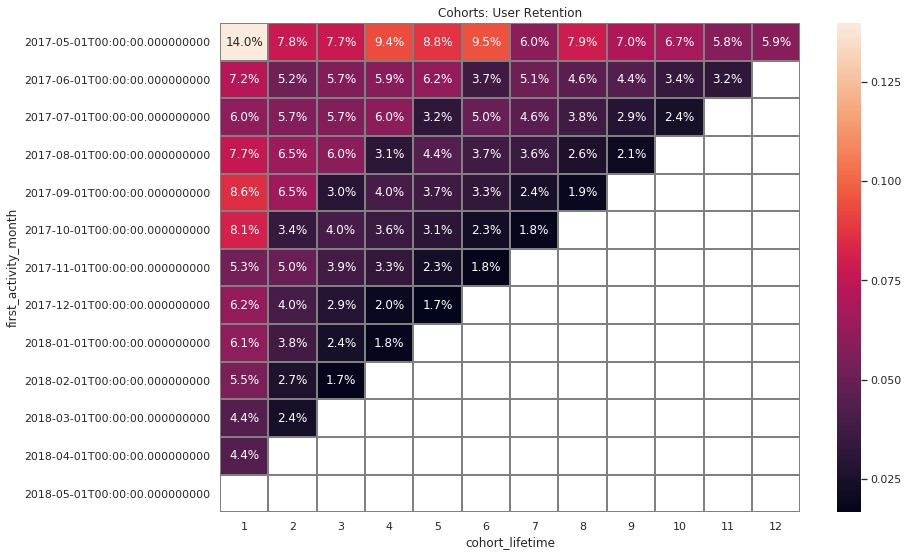

In [ ]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot.iloc[:, 1:], annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 

Самые высокие показатели retention у первой когорты на протяжение всех месяцев. Видим, что даже в последний месяц сохраняется достаточно большой показатель, около 6 процентов. На следующий месяц, после начала пользования видим, что у первой когорты очень высокий по сравнению с остальными показатель, 14 процентов.

#### Продажи
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

##### Когда люди начинают покупать?
<a id="sales1"></a>

In [ ]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [ ]:
visits.head()

,device,end_ts,source_id,start_ts,uid,date,week,month,year,session_duration,first_visit,activity_month,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,18.0,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,28.0,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0.0,2017-07-01 01:54:00,2017-06-01,2017-06-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,24.0,2018-03-09 20:05:00,2018-05-01,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,10,3,2018,28.0,2018-03-09 20:05:00,2018-03-01,2018-03-01,0


В таблице orders есть дата покупки, а в таблице visits дата первого посещения. Объединим эти столбцы и вычтем из даты покупки дату первого посещения

In [ ]:
first_order = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_order.head() # переменная first_visit у нас уже есть

,uid,buy_ts
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


In [ ]:
buying_time = first_visit.merge(first_order, on='uid', how='inner')
buying_time.head()

,uid,first_visit,buy_ts
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [ ]:
buying_time['buying_time'] = (buying_time['buy_ts'] - buying_time['first_visit']).dt.seconds / 60
buying_time.head()

,uid,first_visit,buy_ts,buying_time
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,1382.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,79.0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0


In [ ]:
len(buying_time[buying_time['buying_time'] == 0])

2467

Замечаем, что в таблице присутствует большое количество нулевых значений. То есть время входа на сайт абсолютно равно времени покупки, чего не может быть. Сделаем срез, исключив нулевые значения.

In [ ]:
buying_time = buying_time.query('buying_time != 0')

In [ ]:
buying_time['buying_time'].describe()

count    34056.000000
mean       267.214059
std        439.584023
min          1.000000
25%          5.000000
50%         20.000000
75%        310.000000
max       1439.000000
Name: buying_time, dtype: float64

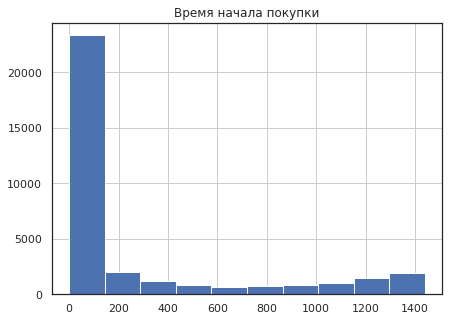

In [ ]:
buying_time['buying_time'].hist(figsize=(7,5))
plt.title('Время начала покупки')
plt.show()

In [ ]:
buying_time['buying_time'].mode()

0    1.0
dtype: float64

Половина пользователей делает первую покупку через 20 минут после первого входа на сайт. 75 процентов покупают спустя несколько часов после первого посещения. Это говорит о том, что большинство покупателей долго не раздумывают о покупке и совершают ее в тот же день.

##### Сколько раз покупают за период?
<a id="sales2"></a>

In [ ]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [ ]:
#orders_and_visits = orders.merge(first_visit)
#orders_and_visits.head()

In [ ]:
orders['buy_date']  = orders['buy_ts'].dt.date
orders['buy_week']  = orders['buy_ts'].dt.week
orders['buy_month']  = orders['buy_ts'].dt.month
orders['buy_year'] = orders['buy_ts'].dt.year

In [ ]:
orders.head()

,buy_ts,revenue,uid,buy_date,buy_week,buy_month,buy_year
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6,2017
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6,2017
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6,2017
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6,2017


Сгруппирует количество покупателей по дате покупки.

In [ ]:
buy_per_day = orders.groupby(['buy_date'])['uid'].agg('count').reset_index()
buy_per_day

,buy_date,uid
0,2017-06-01,96
1,2017-06-02,111
2,2017-06-03,67
3,2017-06-04,66
4,2017-06-05,161
...,...,...
359,2018-05-28,188
360,2018-05-29,189
361,2018-05-30,208
362,2018-05-31,610


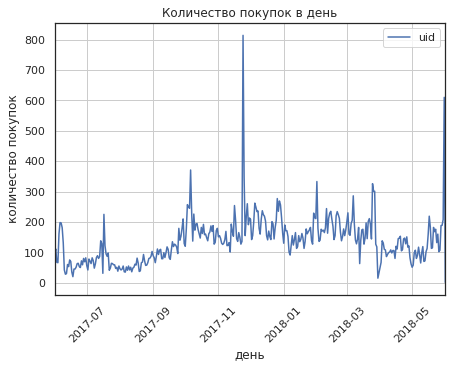

In [ ]:
buy_per_day.plot(x='buy_date', y='uid', grid=True, figsize=(7,5))
plt.xticks(rotation = 45)
plt.title('Количество покупок в день')
plt.xlabel('день')
plt.ylabel('количество покупок')
plt.show()

In [ ]:
buy_per_day['uid'].describe()

count    364.000000
mean     138.502747
std       76.858480
min        1.000000
25%       82.750000
50%      136.000000
75%      177.000000
max      814.000000
Name: uid, dtype: float64

In [ ]:
buy_per_week = orders.groupby(['buy_year','buy_week'])['uid'].agg('count')

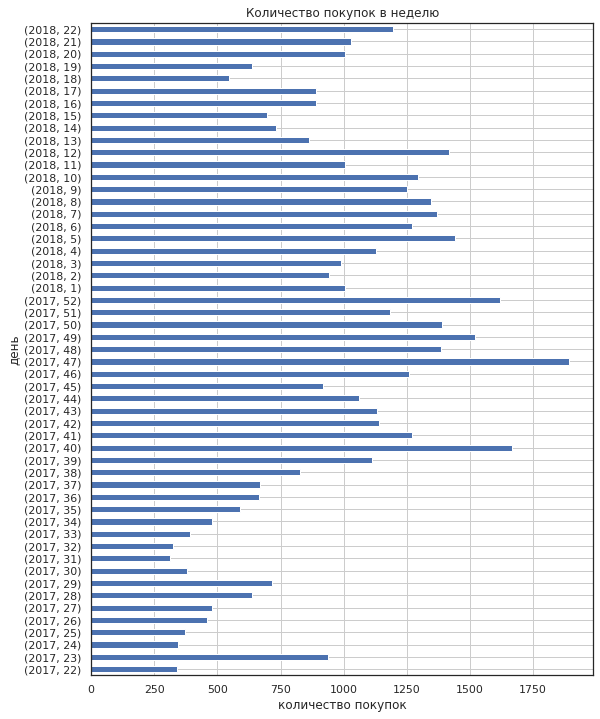

In [ ]:
buy_per_week.plot(figsize=(9,12), grid=True, kind='barh' )
plt.title('Количество покупок в неделю')
plt.xlabel('количество покупок')
plt.ylabel('день')
plt.show()

In [ ]:
buy_per_month = orders.groupby(['buy_year','buy_month'])['uid'].agg('count')


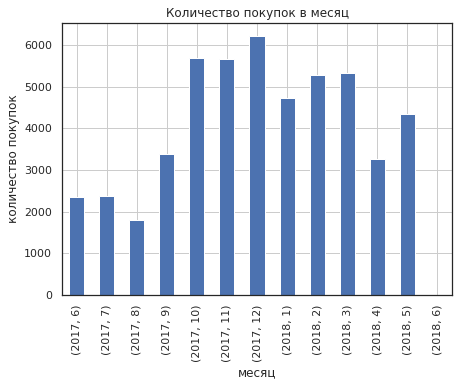

In [ ]:
buy_per_month.plot(kind='bar', figsize=(7,5), grid=True)
plt.title('Количество покупок в месяц')
plt.xlabel('месяц')
plt.ylabel('количество покупок')
plt.show()

Максимум продаж приходится на предновогоднее время (на декабрь).

In [ ]:
orders['uid'].value_counts().mean()

1.3803630588943954

In [ ]:
orders['uid'].value_counts().mode()

0    1
dtype: int64

In [ ]:
orders['uid'].value_counts().head()

3644482766749211722     239
13888745432979765063    238
11920452646463905188    227
6731421022966725351     183
5139615590553126732     150
Name: uid, dtype: int64

В среднем один пользователь делает 1,3 покупки. В модном значении - 1. Есть пользователи, которые совершают более 200 покупок.

##### Какой средний чек?
<a id="sales3"></a>

In [ ]:
orders.head()

,buy_ts,revenue,uid,buy_date,buy_week,buy_month,buy_year
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6,2017
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6,2017
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6,2017
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6,2017


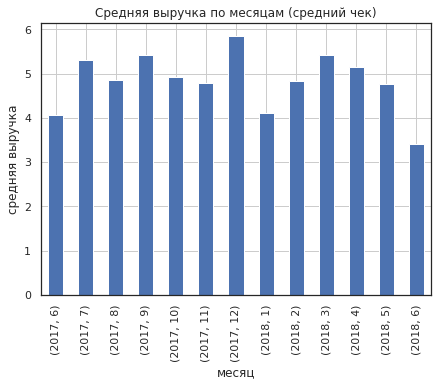

In [ ]:
orders_per_month = orders.groupby(['buy_year','buy_month'])['revenue'].agg('mean')
orders_per_month.plot(kind='bar', grid=True, figsize=(7,5))
plt.title('Средняя выручка по месяцам (средний чек)')
plt.xlabel('месяц')
plt.ylabel('средняя выручка')
plt.show()

В декабре по сравнению с остальными месяцами средний чек выше.

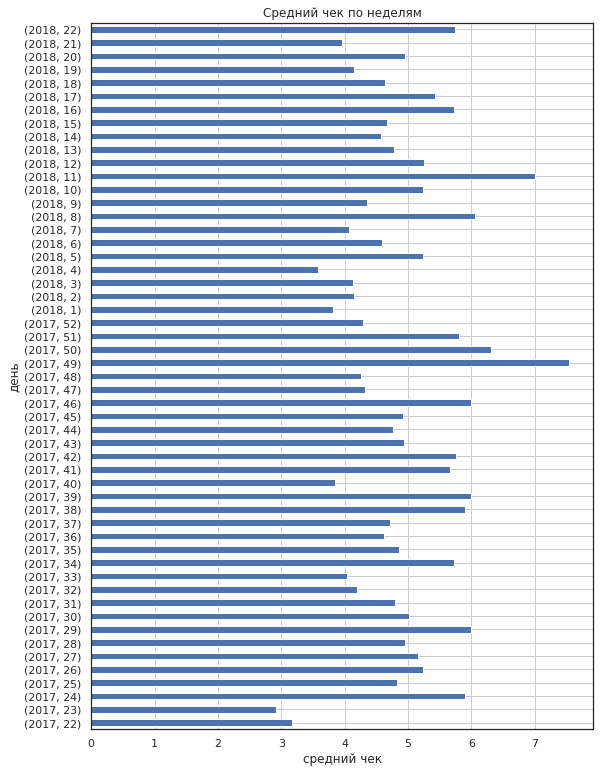

In [ ]:
orders_per_week = orders.groupby(['buy_year','buy_week'])['revenue'].agg('mean')
orders_per_week.plot(kind='barh', figsize=(9,13), grid=True)
plt.title('Средний чек по неделям')
plt.xlabel('средний чек')
plt.ylabel('день')
plt.show()

In [ ]:
orders['revenue'].mean()

4.999646930477041

Средний чек примерно равен 5.


##### Сколько денег приносят? (LTV)
<a id="sales4"></a>

LTV удобно считать по когортам. Данные даны за год. Удобнее всего сформировать месячные когорты. Выделим месяцы из дат в таблицах с заказами и расходами:

In [ ]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
costs['month'] = costs['dt'].astype('datetime64[M]')

In [ ]:
orders.head(1)

,buy_ts,revenue,uid,buy_date,buy_week,buy_month,buy_year,order_month
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01,22,6,2017,2017-06-01


In [ ]:
costs.head(1)

,source_id,dt,costs,month
0,1,2017-06-01,75.2,2017-06-01


In [ ]:
visits.head(1)

,device,end_ts,source_id,start_ts,uid,date,week,month,year,session_duration,first_visit,activity_month,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,18.0,2017-12-20 17:20:00,2017-12-01,2017-12-01,0


Получим месяц первой покупки каждого покупателя:

In [ ]:
first_orders = orders.groupby(['uid']).agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01
...,...,...
36518,18445147675727495770,2017-11-01
36519,18445407535914413204,2017-09-01
36520,18445601152732270159,2018-03-01
36521,18446156210226471712,2018-02-01


Для каждого покупателя найдем источник, с которого он впервые зашел на сайт.

In [ ]:
first_activity_source = visits.sort_values(by='start_ts').groupby('uid', as_index = False).agg({'source_id':'first'})
first_activity_source.name = 'first_activity_source'
first_activity_source.columns = ['uid', 'first_activity_source']
first_activity_source

,uid,first_activity_source
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5
...,...,...
228164,18446403737806311543,5
228165,18446424184725333426,4
228166,18446556406699109058,3
228167,18446621818809592527,4


In [ ]:
first_orders = first_orders.merge(first_activity_source, on='uid', how='left')

In [ ]:
first_orders

,uid,first_order_month,first_activity_source
0,313578113262317,2018-01-01,2
1,1575281904278712,2017-06-01,10
2,2429014661409475,2017-10-01,3
3,2464366381792757,2018-01-01,5
4,2551852515556206,2017-11-01,5
...,...,...,...
36518,18445147675727495770,2017-11-01,5
36519,18445407535914413204,2017-09-01,3
36520,18445601152732270159,2018-03-01,2
36521,18446156210226471712,2018-02-01,3


Посчитаем количество новых покупателей (n_buyers) за каждый месяц:

In [ ]:
cohort_sizes = first_orders.groupby(['first_order_month', 'first_activity_source']).agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'first_activity_source', 'n_buyers']
cohort_sizes

,first_order_month,first_activity_source,n_buyers
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384
...,...,...,...
81,2018-05-01,4,804
82,2018-05-01,5,497
83,2018-05-01,9,60
84,2018-05-01,10,130


In [ ]:
orders_first_month = pd.merge(orders,first_orders, on='uid')
orders_first_month.sample(20)

,buy_ts,revenue,uid,buy_date,buy_week,buy_month,buy_year,order_month,first_order_month,first_activity_source
37944,2018-02-15 13:03:00,4.89,18383218370363884611,2018-02-15,7,2,2018,2018-02-01,2018-02-01,3
18210,2017-10-26 08:54:00,3.30,9905160955007603781,2017-10-26,43,10,2017,2017-10-01,2017-10-01,4
9947,2017-12-04 23:05:00,17.11,11108631484349381433,2017-12-04,49,12,2017,2017-12-01,2017-09-01,9
14455,2017-12-08 10:46:00,1.83,12572041442891018626,2017-12-08,49,12,2017,2017-12-01,2017-10-01,4
31939,2018-01-05 15:59:00,1.83,11617056675817795922,2018-01-05,1,1,2018,2018-01-01,2018-01-01,3
17984,2017-10-23 22:38:00,3.54,10096082937111502144,2017-10-23,43,10,2017,2017-10-01,2017-10-01,9
33459,2018-02-02 14:31:00,2.44,14710589968679378793,2018-02-02,5,2,2018,2018-02-01,2018-01-01,9
40842,2018-03-06 14:35:00,1.83,15619354883861931794,2018-03-06,10,3,2018,2018-03-01,2018-03-01,9
42543,2018-03-18 21:30:00,1.52,14985644822842089024,2018-03-18,11,3,2018,2018-03-01,2018-03-01,4
9942,2017-10-01 00:06:00,14.94,11108631484349381433,2017-10-01,39,10,2017,2017-10-01,2017-09-01,9


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку.

In [ ]:
cohorts_2 = orders_first_month.groupby(['first_order_month','order_month', 'first_activity_source']).agg({'revenue': 'sum'}).reset_index()
cohorts_2.sample(10)

,first_order_month,order_month,first_activity_source,revenue
399,2017-12-01,2018-03-01,4,117.96
113,2017-07-01,2018-01-01,1,71.50
31,2017-06-01,2017-10-01,9,18.19
460,2018-02-01,2018-03-01,9,14.53
341,2017-11-01,2018-01-01,1,312.20
493,2018-03-01,2018-05-01,9,12.71
203,2017-08-01,2018-05-01,1,88.00
273,2017-10-01,2017-10-01,3,5514.40
8,2017-06-01,2017-07-01,2,115.54
491,2018-03-01,2018-05-01,4,96.44


Строка таблицы cohorts показывает, какую выручку принесла когорта из кажого источника.
Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [ ]:
report = pd.merge(cohort_sizes, cohorts_2, on=['first_order_month', 'first_activity_source'])
report

,first_order_month,first_activity_source,n_buyers,order_month,revenue
0,2017-06-01,1,190,2017-06-01,1378.70
1,2017-06-01,1,190,2017-07-01,414.98
2,2017-06-01,1,190,2017-08-01,419.43
3,2017-06-01,1,190,2017-09-01,714.24
4,2017-06-01,1,190,2017-10-01,811.20
...,...,...,...,...,...
511,2018-05-01,4,804,2018-05-01,3802.91
512,2018-05-01,5,497,2018-05-01,2094.04
513,2018-05-01,9,60,2018-05-01,223.05
514,2018-05-01,10,130,2018-05-01,470.89


В первых 5 строках значение количества покупателей не изменяется — ведь это продажи одной и той же когорты.

LTV считают не из выручки, а из валовой прибыли. Значит, нужно найти валовую прибыль, умножив выручку на маржинальность. Также, LTV — относительный показатель. Значит его удобнее смотреть по «возрастным» когортам, где в столбцах — не месяц заказа, а возраст (age) когорты.

In [ ]:
margin_rate = 1
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head(20)

,first_order_month,first_activity_source,n_buyers,order_month,revenue,gp,age
0,2017-06-01,1,190,2017-06-01,1378.70,1378.70,0
1,2017-06-01,1,190,2017-07-01,414.98,414.98,1
2,2017-06-01,1,190,2017-08-01,419.43,419.43,2
3,2017-06-01,1,190,2017-09-01,714.24,714.24,3
4,2017-06-01,1,190,2017-10-01,811.20,811.20,4
5,2017-06-01,1,190,2017-11-01,389.34,389.34,5
6,2017-06-01,1,190,2017-12-01,490.48,490.48,6
7,2017-06-01,1,190,2018-01-01,479.23,479.23,7
8,2017-06-01,1,190,2018-02-01,432.15,432.15,8
9,2017-06-01,1,190,2018-03-01,316.30,316.30,9


Наконец, найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. Для наглядности визуализируем когорты в виде сводной таблицы:

In [ ]:
report['ltv'] = report['gp'] / report['n_buyers']

In [ ]:
report.head(20)

,first_order_month,first_activity_source,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,1,190,2017-06-01,1378.70,1378.70,0,7.256316
1,2017-06-01,1,190,2017-07-01,414.98,414.98,1,2.184105
2,2017-06-01,1,190,2017-08-01,419.43,419.43,2,2.207526
3,2017-06-01,1,190,2017-09-01,714.24,714.24,3,3.759158
4,2017-06-01,1,190,2017-10-01,811.20,811.20,4,4.269474
5,2017-06-01,1,190,2017-11-01,389.34,389.34,5,2.049158
6,2017-06-01,1,190,2017-12-01,490.48,490.48,6,2.581474
7,2017-06-01,1,190,2018-01-01,479.23,479.23,7,2.522263
8,2017-06-01,1,190,2018-02-01,432.15,432.15,8,2.274474
9,2017-06-01,1,190,2018-03-01,316.30,316.30,9,1.664737


In [ ]:
result_ltv = report.pivot_table( index='first_order_month', columns='age', values='ltv', aggfunc='mean')

In [ ]:
#plt.figure(figsize=(13, 9))
#plt.title('LTV по когортам')
#sns.heatmap(result_ltv, annot=True, fmt='.2f', linewidths=1, linecolor='black')

Как видим из графика наибольшую прибыль приносят июньская, сентябрьская и декабрьская когорты.

In [ ]:
test = result_ltv.cumsum(axis=1)
test2 = test.mean(axis=0).to_frame('cumsum mean').T
ltv = pd.concat([test, test2])

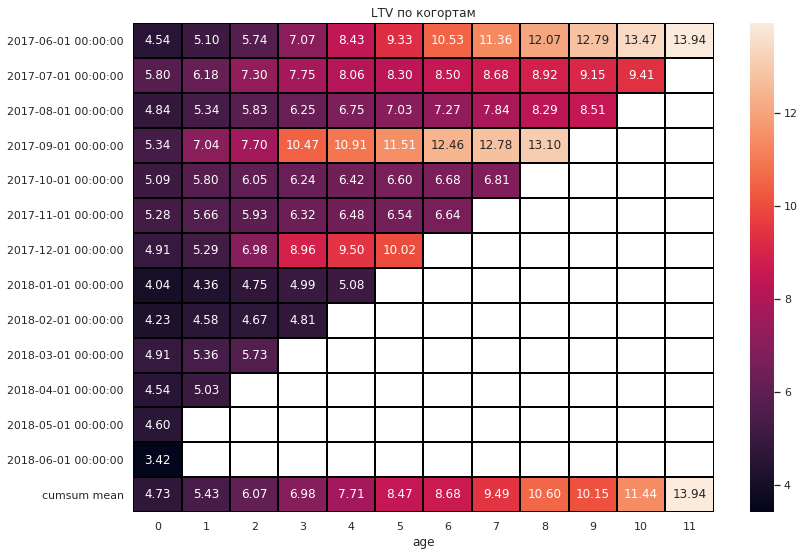

In [ ]:
plt.figure(figsize=(13, 9))
plt.title('LTV по когортам')
sns.heatmap(ltv, annot=True, fmt='.2f', linewidths=1, linecolor='black')

Хорошо заметно, что наибольшую выручку компании принесла июньская, сентябрьская и декабрьская когорты. Также самая нижняя строка показывает средний LTV по каждому месяцу жизни когорт.


#### Маркетинг
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI) Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?

##### Сколько денег потратили? Всего / на каждый источник / по времени
<a id="marketing1"></a>

In [ ]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [ ]:
costs['costs'].sum() # всего денег потратили

329131.62

In [ ]:
costs_source = costs.groupby('source_id')['costs'].sum().reset_index()
costs_source # потратили денег на каждый источник

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


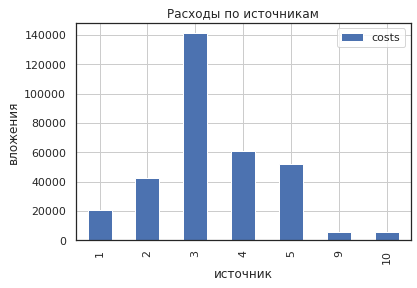

In [ ]:
costs_source.plot(x='source_id', y='costs', grid=True, kind='bar')
plt.title('Расходы по источникам')
plt.xlabel('источник')
plt.ylabel('вложения')
plt.show()

Больше всего денег потратили на третий источник. Меньше всего вкладывается в девятый и десятый.

In [ ]:
costs_month = costs.groupby('month')['costs'].sum().reset_index()
costs_month # потратили денег в месяц

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [ ]:
costs_month['month'] = costs_month['month'].dt.date

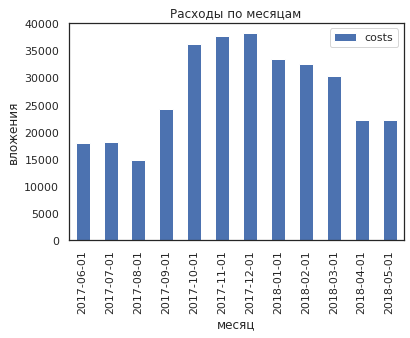

In [ ]:
costs_month.plot(x='month', y='costs', kind='bar')
plt.title('Расходы по месяцам')
plt.xlabel('месяц')
plt.ylabel('вложения')
plt.show()

Наибольшие вложения приходятся на октябрь-декабрь 2017, во время, когда наблюдалась максимальная выручка от продаж.

##### Сколько стоило привлечение одного покупателя из каждого источника?
<a id="marketing2"></a>

CAC (от англ. customer acquisition cost) — стоимость привлечения клиента. Сумма денег, во сколько обходится новый клиент компании.

In [ ]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [ ]:
monthly_costs = costs.groupby(['month', 'source_id']).sum().reset_index() # затраты на каждый источник по месяцам
monthly_costs

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


In [ ]:
report

,first_order_month,first_activity_source,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,1,190,2017-06-01,1378.70,1378.70,0,7.256316
1,2017-06-01,1,190,2017-07-01,414.98,414.98,1,2.184105
2,2017-06-01,1,190,2017-08-01,419.43,419.43,2,2.207526
3,2017-06-01,1,190,2017-09-01,714.24,714.24,3,3.759158
4,2017-06-01,1,190,2017-10-01,811.20,811.20,4,4.269474
...,...,...,...,...,...,...,...,...
511,2018-05-01,4,804,2018-05-01,3802.91,3802.91,0,4.729988
512,2018-05-01,5,497,2018-05-01,2094.04,2094.04,0,4.213360
513,2018-05-01,9,60,2018-05-01,223.05,223.05,0,3.717500
514,2018-05-01,10,130,2018-05-01,470.89,470.89,0,3.622231


In [ ]:
report_new = pd.merge(report, monthly_costs, left_on=['first_order_month', 'first_activity_source'], right_on=['month', 'source_id'])
report_new['cac'] = report_new['costs'] / report_new['n_buyers']

In [ ]:
report_new

,first_order_month,first_activity_source,n_buyers,order_month,revenue,gp,age,ltv,month,source_id,costs,cac
0,2017-06-01,1,190,2017-06-01,1378.70,1378.70,0,7.256316,2017-06-01,1,1125.61,5.924263
1,2017-06-01,1,190,2017-07-01,414.98,414.98,1,2.184105,2017-06-01,1,1125.61,5.924263
2,2017-06-01,1,190,2017-08-01,419.43,419.43,2,2.207526,2017-06-01,1,1125.61,5.924263
3,2017-06-01,1,190,2017-09-01,714.24,714.24,3,3.759158,2017-06-01,1,1125.61,5.924263
4,2017-06-01,1,190,2017-10-01,811.20,811.20,4,4.269474,2017-06-01,1,1125.61,5.924263
...,...,...,...,...,...,...,...,...,...,...,...,...
509,2018-05-01,3,844,2018-05-01,3256.54,3256.54,0,3.858460,2018-05-01,3,9411.42,11.150972
510,2018-05-01,4,804,2018-05-01,3802.91,3802.91,0,4.729988,2018-05-01,4,4214.21,5.241555
511,2018-05-01,5,497,2018-05-01,2094.04,2094.04,0,4.213360,2018-05-01,5,3669.56,7.383421
512,2018-05-01,9,60,2018-05-01,223.05,223.05,0,3.717500,2018-05-01,9,362.17,6.036167


In [ ]:
cac = report_new.groupby(['first_activity_source', 'first_order_month']).agg({'cac': 'mean'}).reset_index()
cac.head(20)

,first_activity_source,first_order_month,cac
0,1,2017-06-01,5.924263
1,1,2017-07-01,6.705500
2,1,2017-08-01,8.423097
3,1,2017-09-01,6.616784
4,1,2017-10-01,6.811029
5,1,2017-11-01,7.546790
6,1,2017-12-01,7.073112
7,1,2018-01-01,9.185630
8,1,2018-02-01,8.016291
9,1,2018-03-01,6.736975


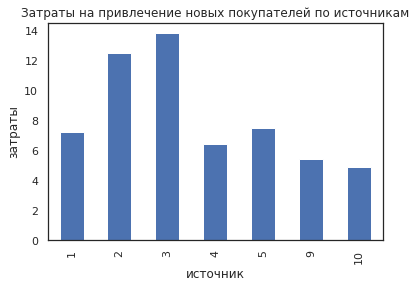

In [ ]:
cac.groupby('first_activity_source')['cac'].agg('mean').plot(kind='bar')
plt.title('Затраты на привлечение новых покупателей по источникам')
plt.xlabel('источник')
plt.ylabel('затраты')
plt.show()

Наибольшие затраты на привлечение одного покупателя приходятся на второй и третий источник, наименьшие на 9 и 10.

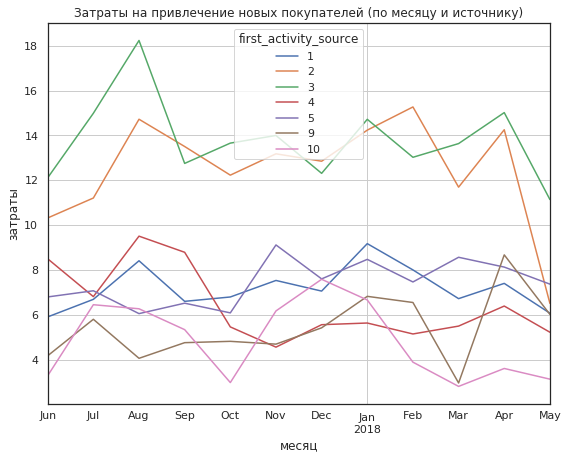

In [ ]:
report_new.pivot_table(index='first_order_month', columns ='first_activity_source', values='cac', aggfunc='mean').plot(figsize=(9,7), grid=True)
plt.title('Затраты на привлечение новых покупателей (по месяцу и источнику)')
plt.xlabel('месяц')
plt.ylabel('затраты')
plt.show()

На графике так же хорошо заметно,что наибольшая стоимость привлечения новых покупателей приходится на второй и третий источник. 

In [ ]:
orders_new = orders.merge(first_activity_source, on='uid', how='inner')
orders_new.head()

,buy_ts,revenue,uid,buy_date,buy_week,buy_month,buy_year,order_month,first_activity_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6,2017,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6,2017,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6,2017,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6,2017,2017-06-01,3


In [ ]:
orders_new.groupby(['order_month','first_activity_source'])['uid'].agg('count').reset_index()

,order_month,first_activity_source,uid
0,2017-06-01,1,268
1,2017-06-01,2,281
2,2017-06-01,3,704
3,2017-06-01,4,467
4,2017-06-01,5,447
...,...,...,...
81,2018-05-01,4,1065
82,2018-05-01,5,641
83,2018-05-01,9,96
84,2018-05-01,10,159


In [ ]:
costs_by_source = costs.groupby(['month','source_id'])['costs'].agg('sum').reset_index()
costs_by_source

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


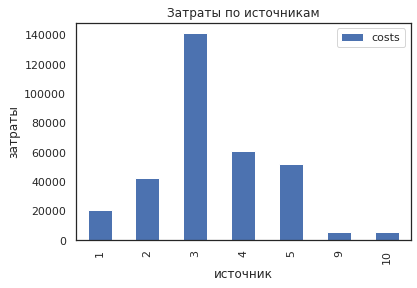

In [ ]:
costs_by_source.groupby('source_id')['costs'].agg('sum').reset_index().plot(kind='bar', x='source_id', y='costs')
plt.title('Затраты по источникам')
plt.xlabel('источник')
plt.ylabel('затраты')
plt.show()

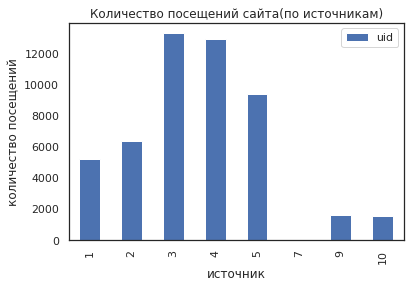

In [ ]:
orders_first_month.groupby('first_activity_source')['uid'].agg('count').reset_index().plot(kind='bar', x='first_activity_source', y='uid')
plt.title('Количество посещений сайта(по источникам)')
plt.xlabel('источник')
plt.ylabel('количество посещений')
plt.show()

Наибольшие затраты на привлечений покупателей пришлись на второй и третий источники. Третий источник имеет хорошие показатели по посещаемости.

In [ ]:
cac.head()

,first_activity_source,first_order_month,cac
0,1,2017-06-01,5.924263
1,1,2017-07-01,6.705500
2,1,2017-08-01,8.423097
3,1,2017-09-01,6.616784
4,1,2017-10-01,6.811029


In [ ]:
report_new['cac'].mean()

8.50215567312589

In [ ]:
costs['costs'].sum() / orders['uid'].nunique()
# можно еще разделить сумму всех расходов на общее количество привлеченных клиентов за весь период

9.011626098622786

In [ ]:
cac.groupby('first_activity_source')['cac'].agg('mean')

first_activity_source
1      7.212107
2     12.504068
3     13.802743
4      6.439374
5      7.451938
9      5.413892
10     4.867125
Name: cac, dtype: float64

В среднем стоимость привлечения одного клиента компании обошлась в 8-9. Среди источников наиболее дорого обошлись новые пользователи, пришедшие из 2 и 3 источника (12-13), 1,4 и 5 источники - 6-7. И наименьшие затраты на привлечение новых клиентов у 9 и 10 источника (4-5).

##### На сколько окупились расходы? (ROI) Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?
<a id="marketing3"></a>

In [ ]:
report_new['romi'] = report_new['ltv'] / report_new['cac']

In [ ]:
report_new.head()

,first_order_month,first_activity_source,n_buyers,order_month,revenue,gp,age,ltv,month,source_id,costs,cac,romi
0,2017-06-01,1,190,2017-06-01,1378.70,1378.70,0,7.256316,2017-06-01,1,1125.61,5.924263,1.224847
1,2017-06-01,1,190,2017-07-01,414.98,414.98,1,2.184105,2017-06-01,1,1125.61,5.924263,0.368671
2,2017-06-01,1,190,2017-08-01,419.43,419.43,2,2.207526,2017-06-01,1,1125.61,5.924263,0.372625
3,2017-06-01,1,190,2017-09-01,714.24,714.24,3,3.759158,2017-06-01,1,1125.61,5.924263,0.634536
4,2017-06-01,1,190,2017-10-01,811.20,811.20,4,4.269474,2017-06-01,1,1125.61,5.924263,0.720676


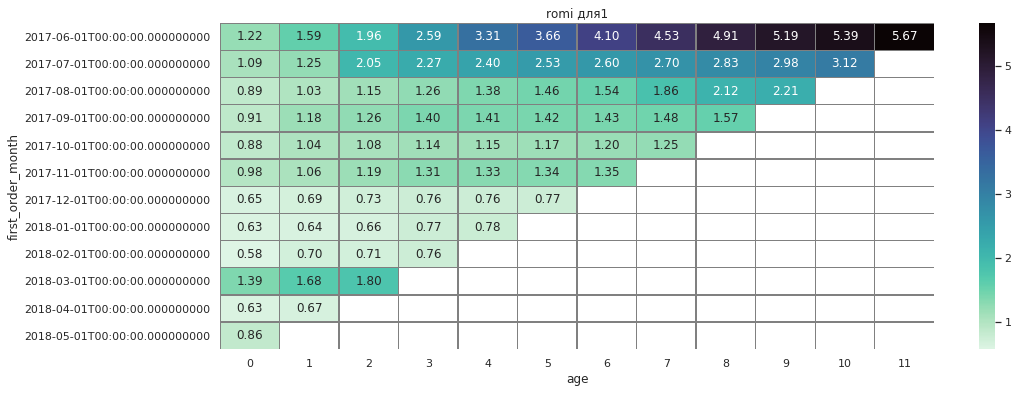

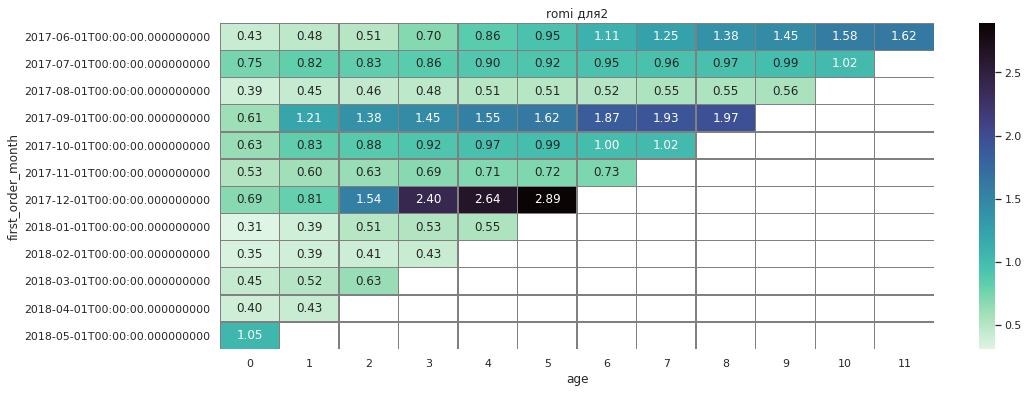

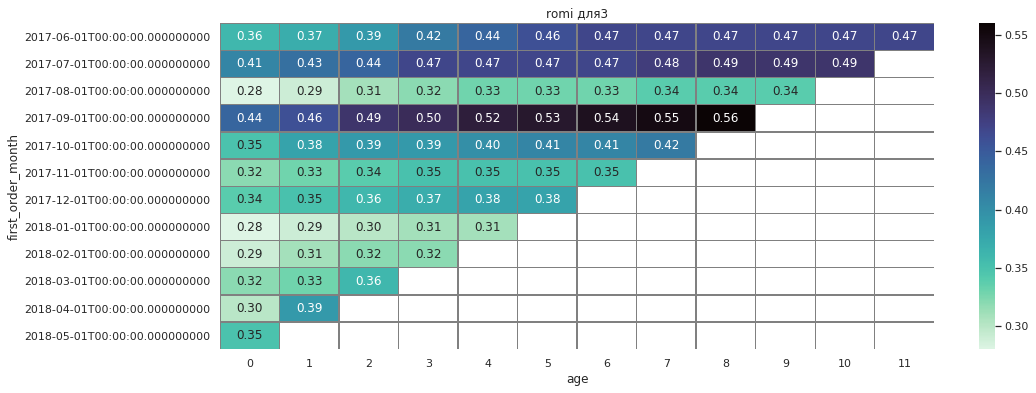

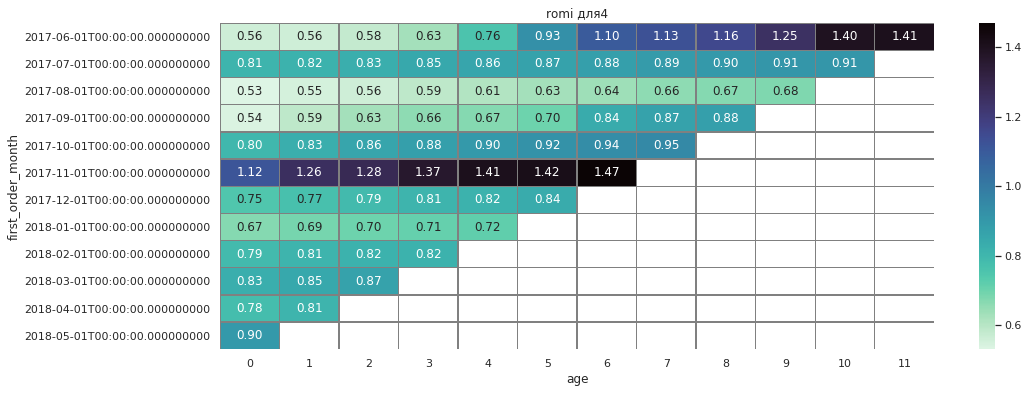

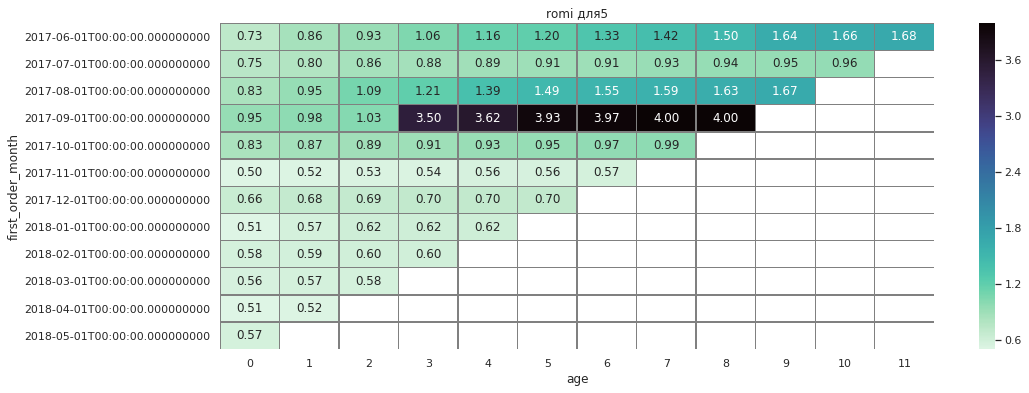

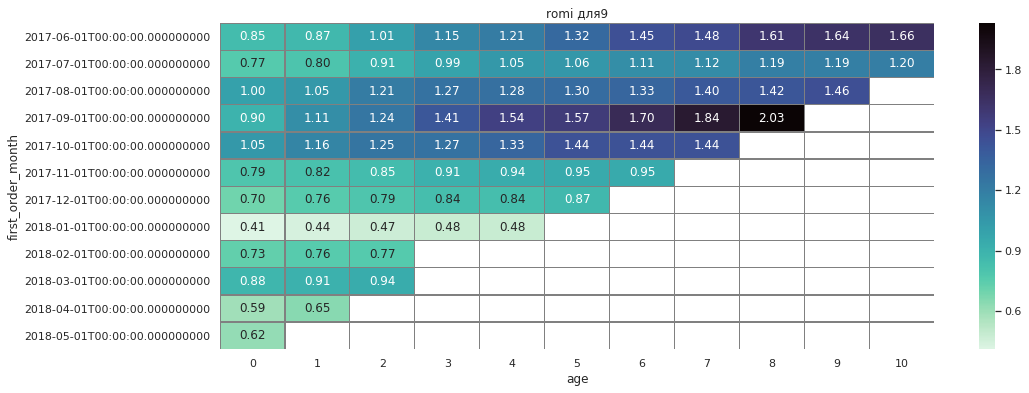

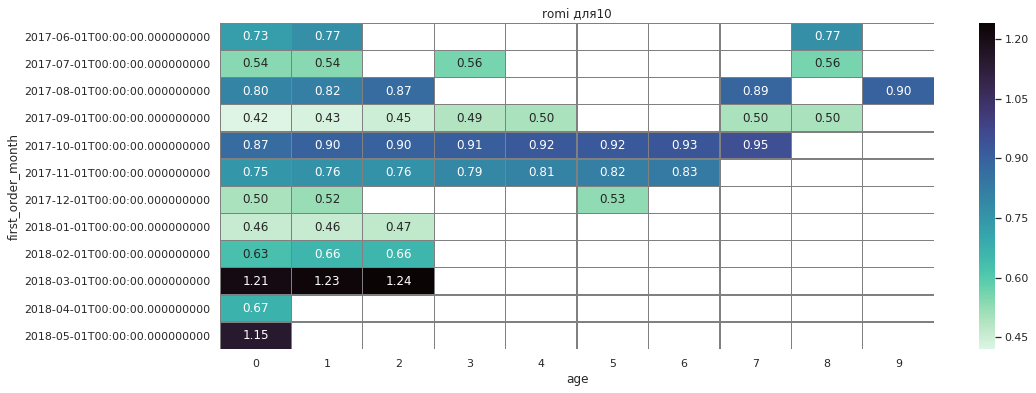

In [ ]:
for source in report_new.first_activity_source.unique():
    output = report_new.query('first_activity_source == @source').pivot_table(index = 'first_order_month',
    columns = 'age',
    values = 'romi',
    aggfunc = 'mean').round(2).cumsum(axis=1)
    plt.figure(figsize=(16,6))
    ax = sns.heatmap(output, linewidths=0.3, annot=True, fmt='.2f', linecolor='gray', cmap='mako_r')
    ax.set_title('romi для' +str(source))
    plt.show()

Посмотрим на значение romi вне зависимости от когорт, а среднее значение по каждому источнику. Так как смотеть на такое большое количество графиков очень неудобно.

In [ ]:
romi = []
for source in report_new['first_activity_source'].unique():
    roi_per_source = report_new.query('first_activity_source == @source').pivot_table(index = 'first_order_month', columns = 'age', values='romi', aggfunc='mean').mean(axis=0).sum().round(2)
    romi.append([source, roi_per_source])
roi_per_source = pd.DataFrame(romi, columns=['source','romi'])
roi_per_source

,source,romi
0,1,2.73
1,2,1.43
2,3,0.42
3,4,1.13
4,5,1.40
5,9,1.32
6,10,0.84


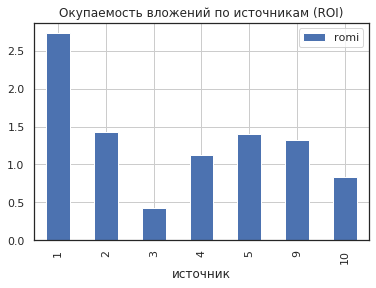

In [ ]:
roi_per_source.plot(kind='bar', x='source', y='romi', grid=True)
plt.title('Окупаемость вложений по источникам (ROI)')
plt.xlabel('источник')
plt.show()

Как видим, исходя из графика, хуже всего окупается третий источник. Как мы рассматривали выше это именно тот источник, в который компания вкладывает больше всего денег и которой каждый новый клиент обходится дороже, чем в остальных источниках. Но в то же время третий источник является лидером по количеству посетителей и покупателей. Поэтому вложение средств в этот источник снижать нельзя, так как он приносит сайту много новых клиентов.
Лучше всего окупается первый источник.

### Шаг 3. Вывод
<a id="conclusion"></a>

Подведем итоги нашего исследования информации о посещениях и заказах на сайте яндекс.афиша. В нашем распоряжении были данные о посещениях сайта за годовой отрезок времени, информация о заказах, сделанных на сайте и всех маркетинговых затратах за представленный период времени.
Итак, для начала мы проанализировали количество посещений сайта в разные отрезки времени. Рассчитали такие мерики, как: DAU, WAU, MAU.
- В среднем сайт ежедневно посещает 900 человек. 
- Наибольшее количество посетителей приходится на ноябрь и декабрь. Также охотно преобретают билеты на культурные мероприятия Яндекс.Афиши в первые три месяца 2018 года. В летнее время наблюдается спад в спросе на покупку билетов, что связано прежде всего с тем, что летом проводится меньше мероприятий, театры как правило заканчивают театральный сезон и уходят на каникулы.
- Максимальное количество посетителей приходится на 24 ноября 2017 года. Как мы знаем, в этот день проводилась ежегодная акция "черная пятница", день глобальных скидок и распродаж. В этот день сайт посетило больше 3 тысяч человек.

Количество сессий в день примерно равно количеству уникальных посещений, что говорит о том, что посетители как правило не заходят более одного раза в день. Длина сессии в среднем составляет 10 минут.
Затем мы разделили всех пользователей на когорты по месяцу первого посещения Яндекс.Афиши и рассчитали для каждой когорты сколько пользователей вернулось в последующие месяцы. По метрике Retention Rate можем сделать следующие выводы:
- Самые высокие показатели retention у первой когорты на протяжение всех месяцев. Даже в последний месяц сохраняется достаточно большой показатель, около 6 процентов. На следующий месяц, после начала использования у первой когорты очень высокий по сравнению с остальными показатель, 14 процентов.

Половина посетителей начинает совершать покупку через 20 минут после входа на сайт. 75 процентов всех покупателей совершают заказ в ближайшие несоклько часов. Наиболее часто встречающееся значение(мода) - 1 минута. Это говорит о том, что посетители как правило целенаправленно заходят на сайт и долго о покупке не размышляют.

По окупаемости лидирует первый источник, но по количеству посещений от уступает драугим источникам. 
Лидер по количеству посещений - третий источник. Но в то же время каждый новый покупатель из третьего источника обходится компании дороже всего. Как мы уже писали выше, снижать вожения в этот источник не стоит, так как он приносит компании наибольшую выручку. Я бы обратила внимание на 4 и 5 источники. Так как у них неплохие показатели по посещаемости, а вот вложения в эти источники у них невысокие.